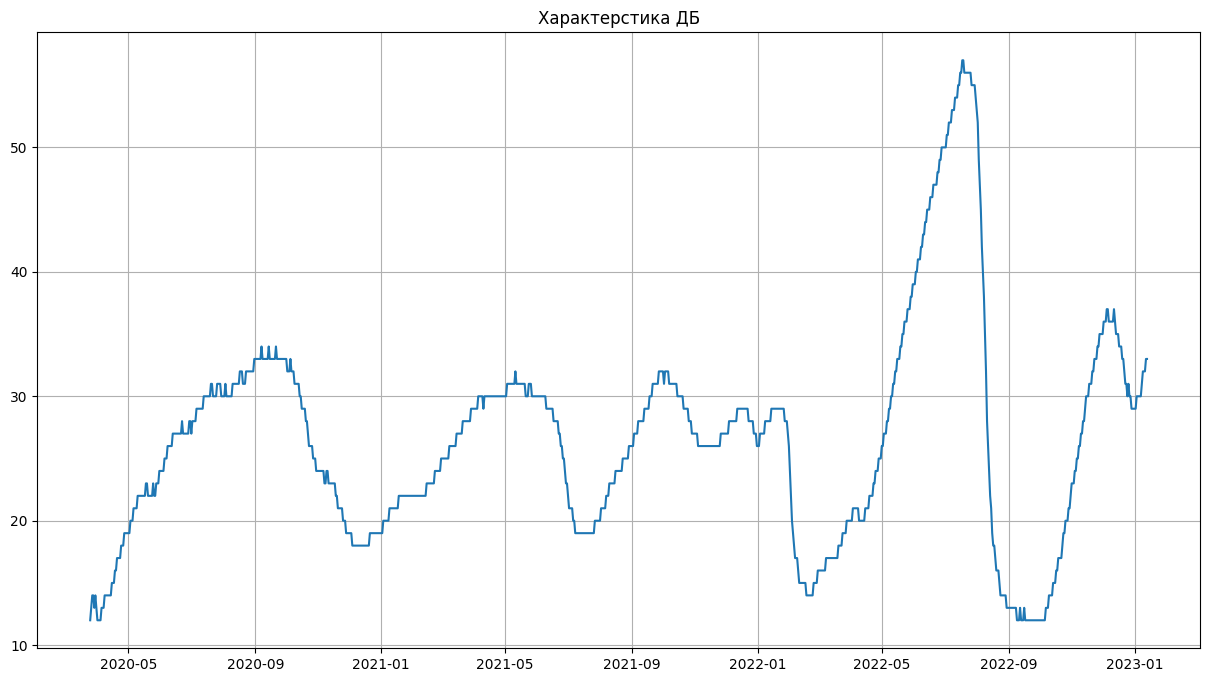

In [ ]:
#@title
import os
import datetime
import random
import itertools
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def get_hdb(df):
    n = df.shape[0]
    hdb = np.zeros(n)
    for index_recover in range(n):
        for index_noticed in range(index_recover, 0, -1):
            if df['Выздоровевших и умерших'].iloc[index_recover]<=df['Выявлено всего'].iloc[index_noticed]:
                hdb[index_recover] = index_recover-index_noticed
    return hdb

mpl.rcParams['figure.figsize'] = (15, 8)
mpl.rcParams['axes.grid'] = False

seed_everything()
df = pd.read_csv('data_yandex.csv', sep=";")
df.reset_index(drop=True, inplace=True)
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%Y-%m-%d %H:%M:%S")
df.rename(columns={'DateTime': 'Дата', 'Заражений': 'Выявлено всего'}, inplace=True)

df['% Выздоровлений'] = df['Выздоровлений'].pct_change()
df['% Смертей'] = df['Смертей'].pct_change()
df['% прирост'] = df['Выявлено всего'].pct_change()
df.rename(columns={'DateTime': 'Дата'}, inplace=True)
df['Выздоровевших и умерших'] = df['Выздоровлений'] + df['Смертей']
df['Выздоровевших и умерших'] = df['Выздоровевших и умерших']

df['Характерстика ДБ'] = get_hdb(df)

df = df[['Дата', 'Выявлено всего', 'Выздоровевших и умерших', 'Заражений за день', '% прирост', 'Выздоровлений', 'Выздоровлений за день', '% Выздоровлений', 'Смертей', 'Смертей за день', '% Смертей', 'Летальность, %', 'Характерстика ДБ']]

df = df.drop(index=df[df['% прирост']>1].index)
df.dropna(inplace=True)

timestamp_s = df['Дата'].map(pd.Timestamp.timestamp)

day = 24*60*60*210

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_search = df[['Дата', 'Заражений за день', 'Day sin', 'Day cos', 'Характерстика ДБ']]
df_search = df_search.set_index('Дата')
df_search.dropna(inplace=True)
plt.plot(df_search['Характерстика ДБ'])
plt.grid()
plt.title('Характерстика ДБ')
plt.show()

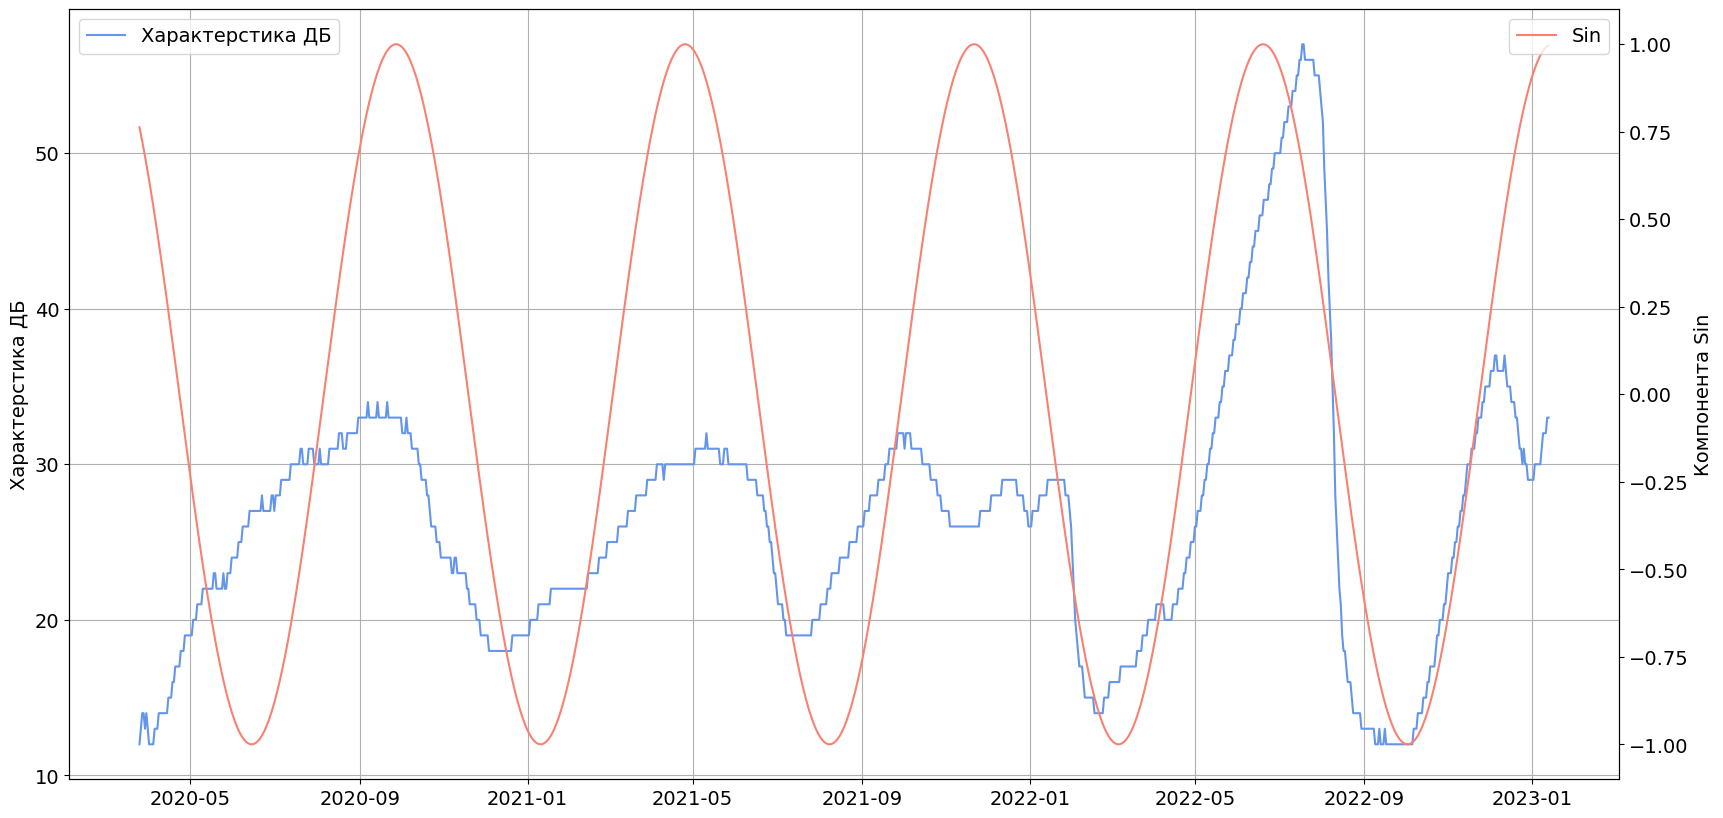

In [ ]:
mpl.rcParams.update({'font.size': 14})

mpl.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(df_search.index, df_search['Характерстика ДБ'], label='Характерстика ДБ',color='cornflowerblue')
ax1 = ax.twinx()
ax1.plot(df_search.index, df_search['Day sin'], label='Sin', color='salmon')
# ax1.plot(df_search.index, df_search['Day cos'], label='Cos')
ax.grid()
ax.set_ylabel('Характерстика ДБ')
ax1.set_ylabel('Компонента Sin')
ax.legend(loc='upper left')
ax1.legend(loc='upper right')
plt.show()

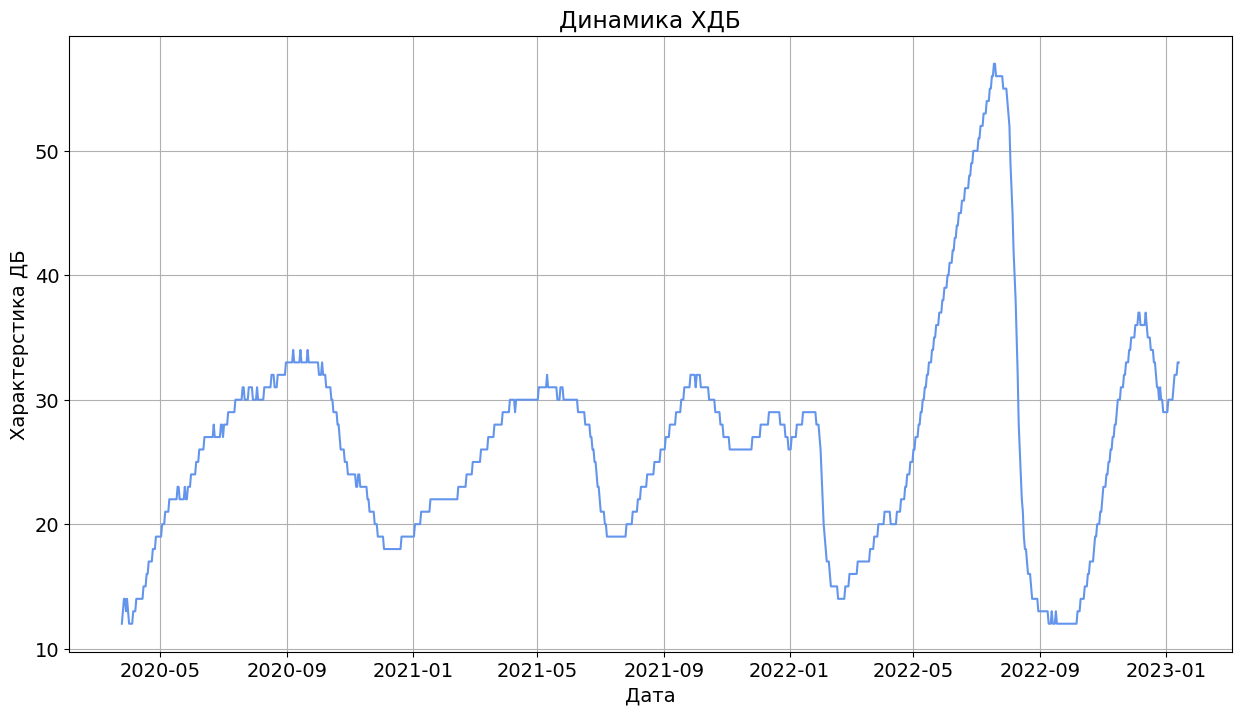

In [ ]:
mpl.rcParams.update({'font.size': 14})
plt.plot(df_search.index, df_search['Характерстика ДБ'], label='Характерстика ДБ',color='cornflowerblue')
plt.ylabel('Характерстика ДБ')
plt.xlabel('Дата')
plt.title('Динамика ХДБ')
plt.grid()
plt.show()

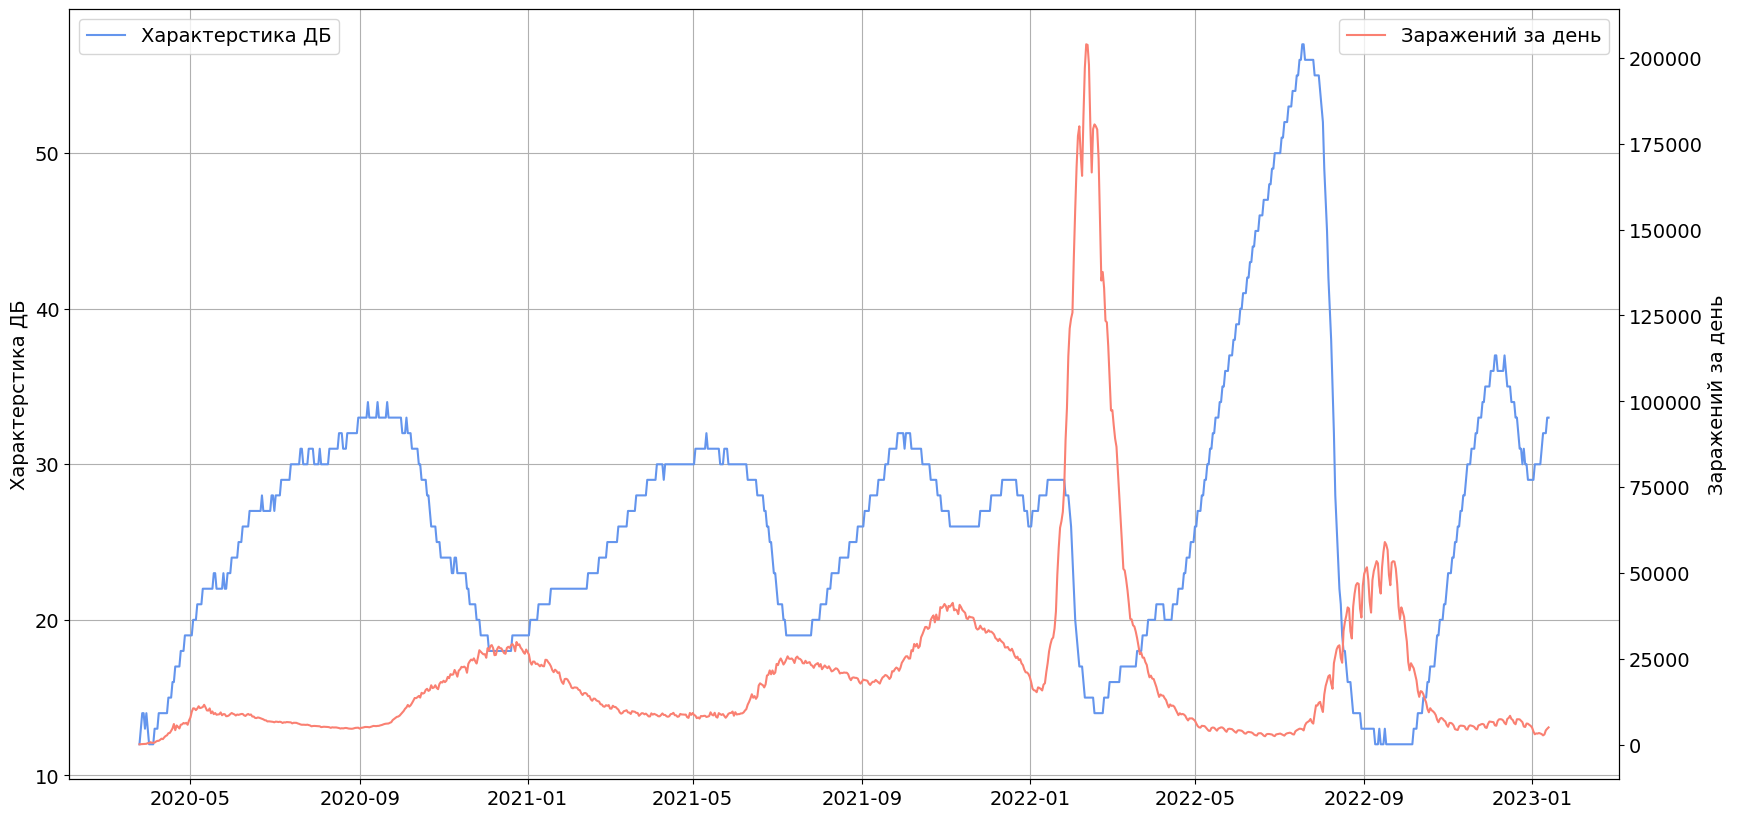

In [ ]:
mpl.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(df_search.index, df_search['Характерстика ДБ'], label='Характерстика ДБ',color='cornflowerblue')
ax1 = ax.twinx()
ax1.plot(df_search.index,df_search['Заражений за день'], label='Заражений за день', color='salmon')
ax.grid()
ax.set_ylabel('Характерстика ДБ')
ax1.set_ylabel('Заражений за день')
ax.legend(loc='upper left')
ax1.legend(loc='upper right')
plt.show()

In [ ]:
class config():
    def __init__(self, data: pd.DataFrame):
        self.patience = 10
        self.per_train_split = 0.90
        self.per_val_split = 0.95
        self.window_size_MA = 7
        self.n_future = 20
        self.season_day = 200
        self.batch_size = 128
        self.epochs = 50
        self.step = 1
        self.window_size = int(1.25*max(self.n_future, self.season_day))
        self.n_samples = data.shape[0]
        self.train_split = int(self.n_samples*self.per_train_split)
        self.val_split = int(self.n_samples*self.per_val_split)
        self.num_features = data.shape[1]
        self.seed = 0
        self.metrics = ['mean_squared_error']
        self.steps_per_epoch = 50
        self.validation_steps = 20

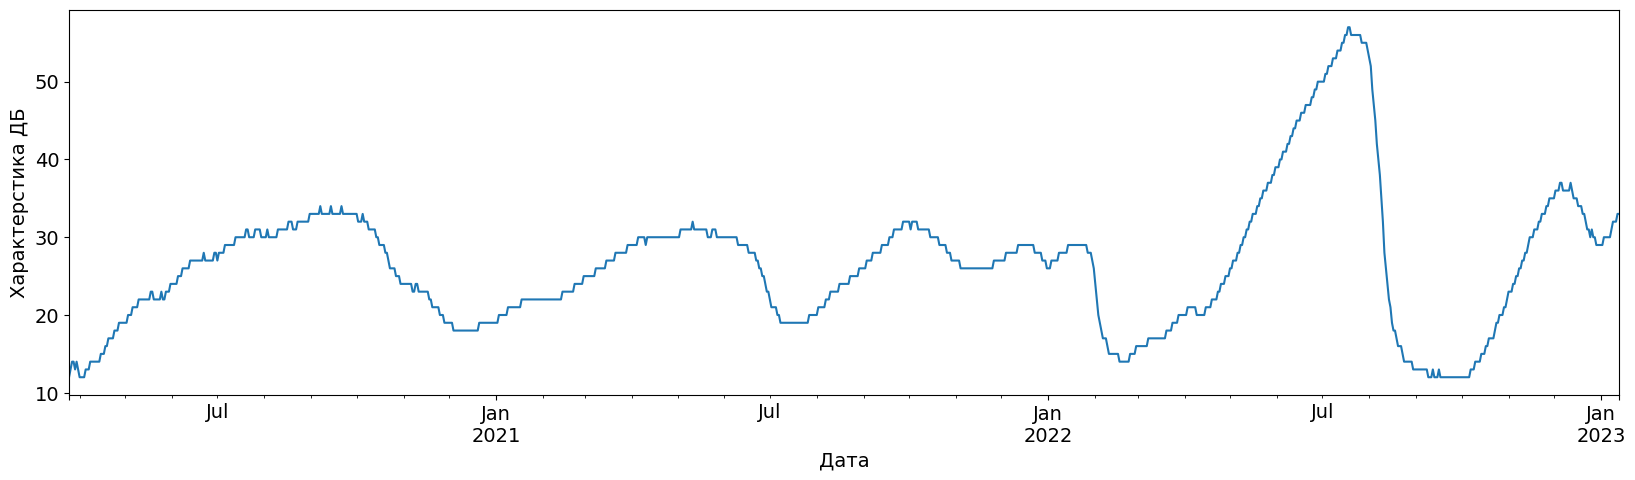

In [ ]:
conf = config(df_search)

mpl.rcParams['figure.figsize'] = (20, 5)
mpl.rcParams['axes.grid'] = False
ax = df_search['Характерстика ДБ'].plot()
# plt.title('Характерстика ДБ')
# plt.axvline(df_search.index[conf.train_split], color='k', linestyle='--')
# plt.axvline(df_search.index[conf.val_split], color='b', linestyle='--')
# plt.grid()
plt.ylabel('Характерстика ДБ')
plt.show()


# plt.plot(df_search['Характерстика ДБ'])
# plt.grid()
# plt.title('Характерстика ДБ')
# plt.axvline(df_search.index[conf.train_split], color='k', linestyle='--')
# plt.axvline(df_search.index[conf.val_split], color='b', linestyle='--')
# plt.show()

# ax = df_search.plot(subplots=True)
# for ax_i in ax:
#     ax_i.axvline(df_search.index[conf.train_split], color='k', linestyle='--')
#     ax_i.axvline(df_search.index[conf.val_split], color='b', linestyle='--')
# plt.show()

## Linear model

In [ ]:
conf = config(df_search)
seed_everything(conf.seed)

data_train = df_search.iloc[:conf.train_split, :]
data_test = df_search.iloc[conf.train_split:, :]

X_train, y_train = data_train.iloc[:, :-1],  data_train.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1],  data_test.iloc[:, -1]

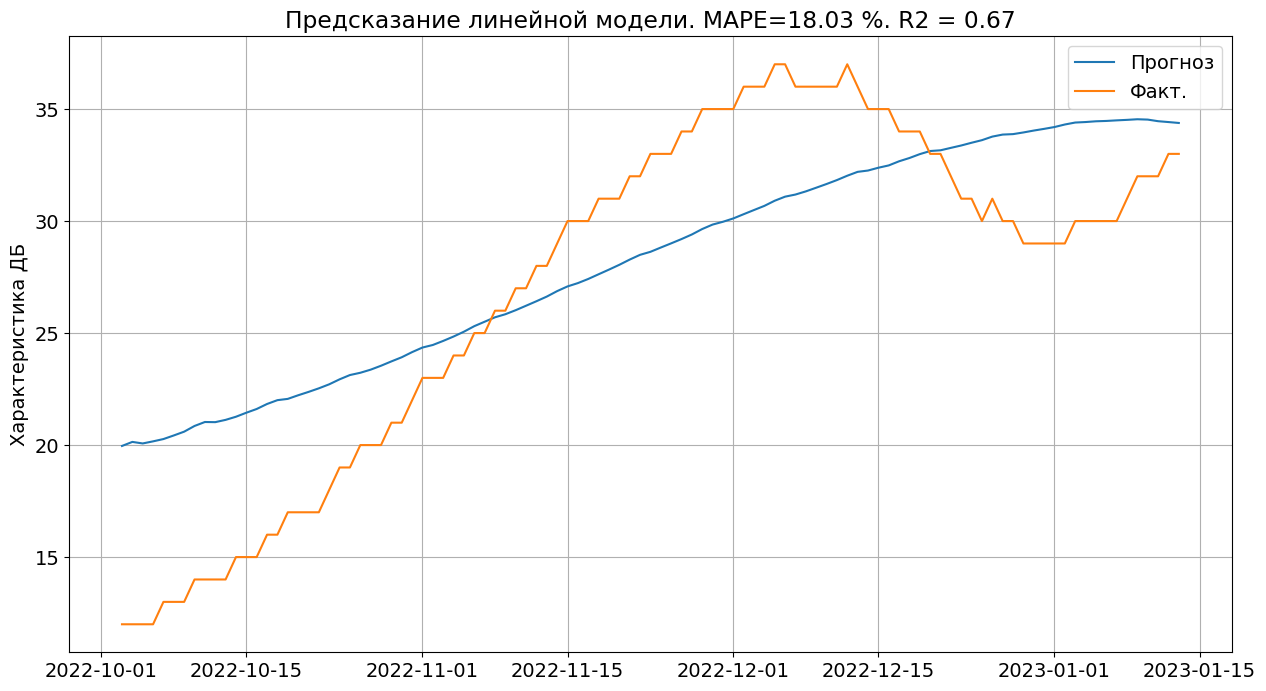

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_linear = reg.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred_linear)*100
r2 = r2_score(y_test, y_pred_linear)
plt.plot(X_test.index, y_pred_linear, label='Прогноз')
plt.plot(X_test.index, y_test, label='Факт.')
plt.title(f'Предсказание линейной модели. MAPE={round(mape, 2)} %. R2 = {round(r2, 2)}')
plt.ylabel('Характеристика ДБ')
plt.grid()
plt.legend()

## Polynomial

Лучшая степень 1 для RMSE 9.019156977852793,
		 1 для MAE 8.64394914407472,
		 0 для R2 0.01


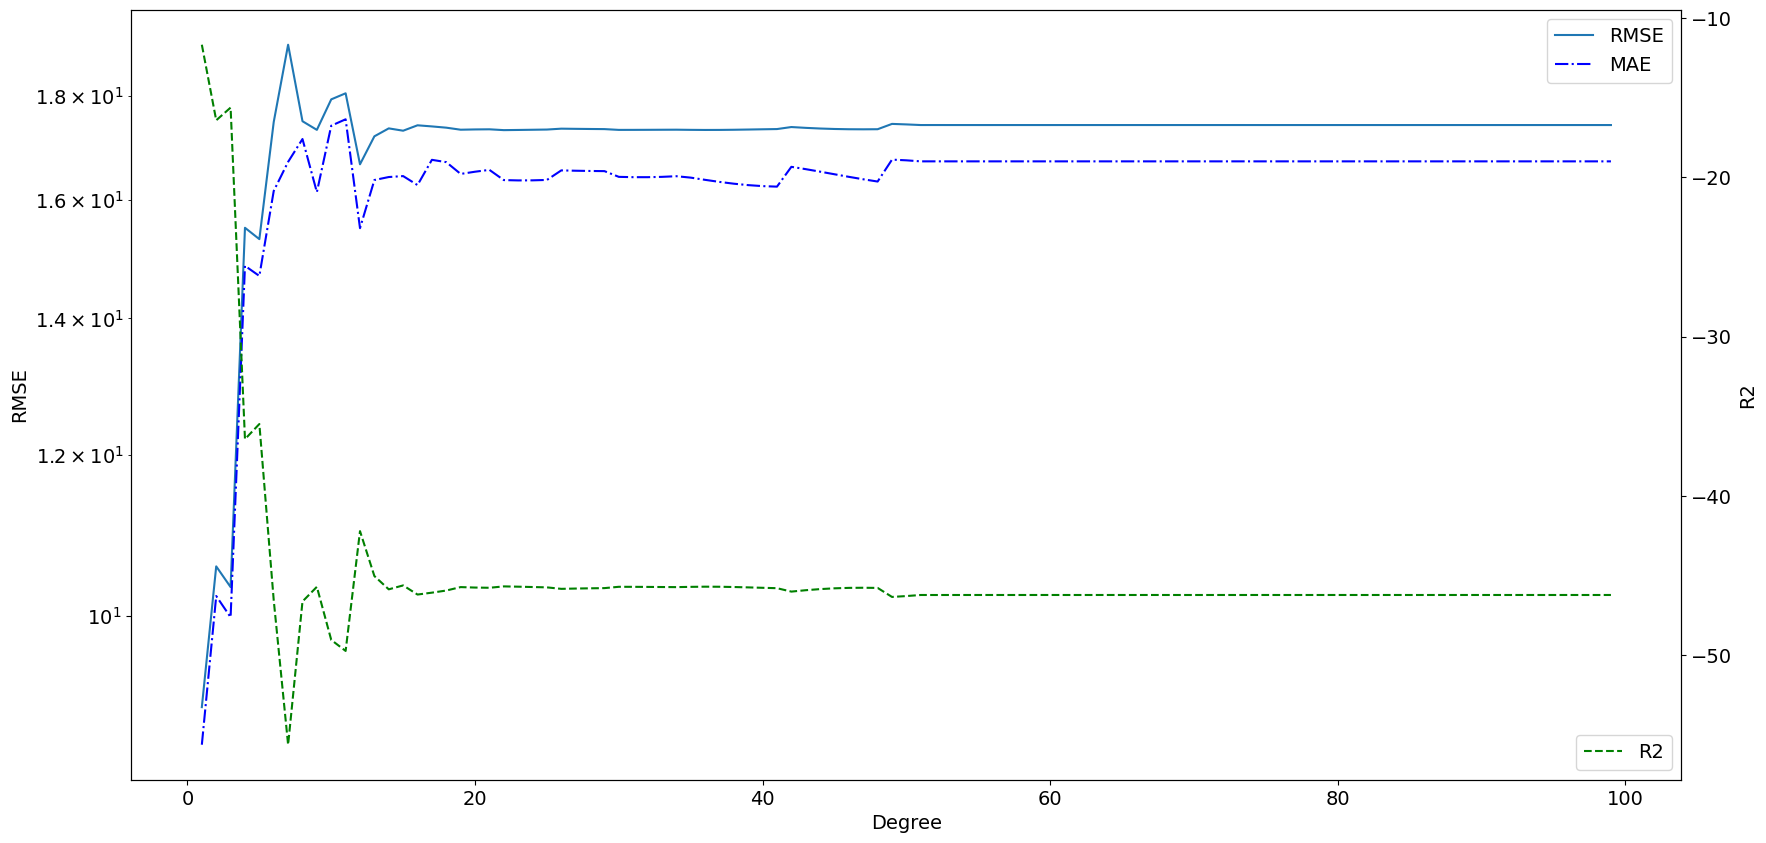

In [ ]:
seed_everything()

data_train = df_search.iloc[:conf.val_split, :]
data_test = df_search.iloc[conf.val_split:, :]

X_train, y_train = data_train.iloc[:, :-1],  data_train.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1],  data_test.iloc[:, -1]

x_train = np.arange(X_train.shape[0])
x_test = np.arange(X_test.shape[0])

rmses = []
maes = []
r2_scores = []
degrees = np.arange(1, 100)
min_rmse, min_mae, max_r2, min_deg, min_deg_mae, min_deg_r2 = 1e10, 1e10, 0.01, 0, 0, 0

for deg in degrees:

    model = np.polyfit(x = x_train, y = y_train, deg = deg)
    polynom = np.poly1d(model)

    df_polynom = pd.DataFrame(data=polynom(x_test))
    df_polynom = df_polynom.set_index(X_test.index)
    df_polynom.columns = ['Характерстика ДБ']
        
    # 1. RMSE:
    poly_mse = mean_squared_error(y_test, df_polynom) # Mean Square Error
    poly_rmse = np.sqrt(poly_mse) # Root Mean Square Root
    rmses.append(poly_rmse)
    
    # 2. MAE:
    poly_mae = mean_absolute_error(y_test, df_polynom)
    maes.append(poly_mae)
    
    # 3. R2 - score:
    poly_r2_score = r2_score(y_test.tolist(), df_polynom)
    r2_scores.append(poly_r2_score)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg
    if min_mae > poly_mae:
        min_mae = poly_mae
        min_deg_mae = deg
    if max_r2 < poly_r2_score:
        max_r2 = poly_r2_score
        min_deg_r2 = deg

IPython.display.clear_output()
# Plot and present results
print('Лучшая степень {} для RMSE {},\n\t\t {} для MAE {},\n\t\t {} для R2 {}'.format(min_deg, min_rmse, min_deg_mae, min_mae, min_deg_r2, max_r2))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(degrees, rmses, label='RMSE')
ax2 = ax.twinx()
ax.plot(degrees, maes, 'b-.', label='MAE')
ax2.plot(degrees, r2_scores, 'g--', label='R2')
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax2.set_ylabel('R2')
ax.set_ylabel('MAE')
ax.set_ylabel('RMSE')
# ax.axvline(16, linestyle='--')
ax.legend(loc='upper right')
ax2.legend(loc='lower right')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


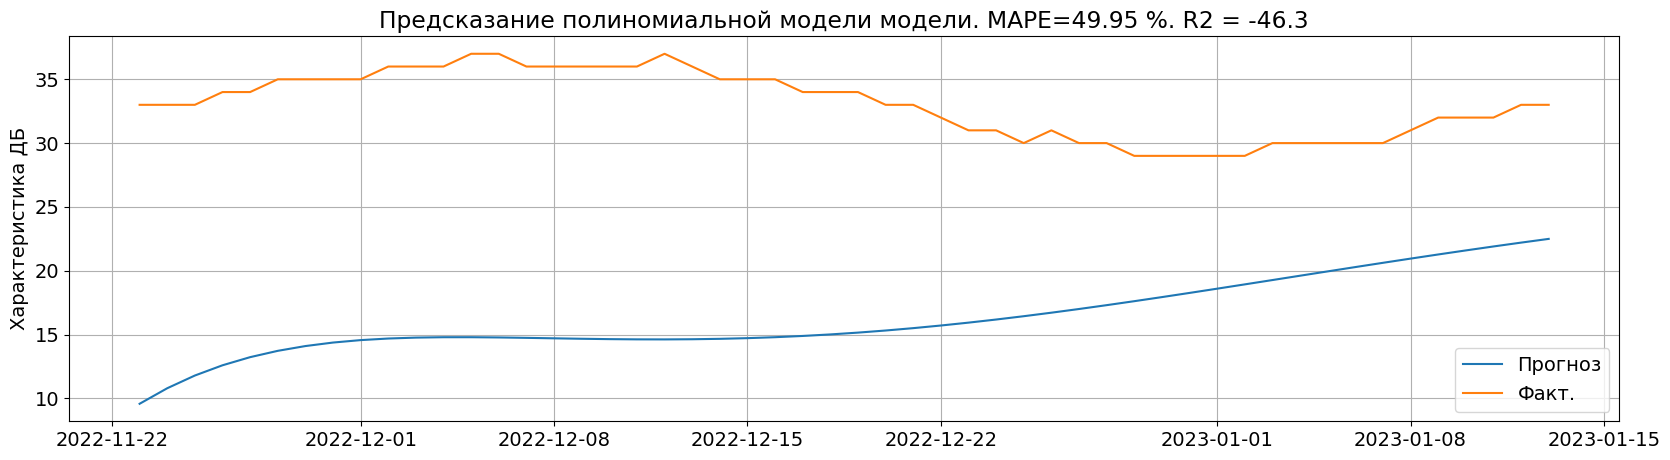

In [ ]:
data_train = df_search.iloc[:conf.val_split, :]
data_test = df_search.iloc[conf.val_split:, :]

X_train, y_train = data_train.iloc[:, :-1],  data_train.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1],  data_test.iloc[:, -1]

x_train = np.arange(X_train.shape[0])
x_test = np.arange(X_test.shape[0])

model = np.polyfit(x = x_train, y = y_train, deg = 50)
polynom = np.poly1d(model)

df_polynom = pd.DataFrame(data=polynom(np.arange(X_test.shape[0])))
df_polynom = df_polynom.set_index(X_test.index)
df_polynom.columns = ['Характерстика ДБ']

mape = mean_absolute_percentage_error(y_test, df_polynom)*100
r2 = r2_score(y_test, df_polynom)
plt.plot(X_test.index, df_polynom, label='Прогноз')
plt.plot(X_test.index, y_test, label='Факт.')
plt.title(f'Предсказание полиномиальной модели модели. MAPE={round(mape, 2)} %. R2 = {round(r2, 2)}')
plt.ylabel('Характеристика ДБ')
plt.grid()
plt.legend()

## Holt winters smoothing

In [ ]:
data_train = df_search.iloc[:conf.train_split, :]
data_val = df_search.iloc[conf.train_split:conf.val_split, :]
data_test = df_search.iloc[conf.train_split:, :]

window_size = [30, 45, 60, 90, 120, 180, 210]
mape = []
r2 = []
for window in window_size:
    fitted_model = ExponentialSmoothing(data_train['Характерстика ДБ'],trend='mul',seasonal='mul',seasonal_periods=window).fit()
    y_pred_holter_winters = fitted_model.forecast(data_test.shape[0])
    mape_test = mean_absolute_percentage_error(data_test['Характерстика ДБ'], y_pred_holter_winters)
    mape.append(mape_test)
    r2_test = r2_score(data_test['Характерстика ДБ'], y_pred_holter_winters)
    r2.append(r2_test)
# data_train['Характерстика ДБ'].plot(legend=True,label='TRAIN')
# data_val['Характерстика ДБ'].plot(legend=True,label='TEST',figsize=(6,4))
# test_predictions.plot(legend=True,label='PREDICTION')
# plt.title('Train, Test and Predicted Test using Holt Winters')

In [ ]:
mape

[0.49761480483192827,
 0.4459619024181211,
 0.5059520768433681,
 0.5573655380076827,
 0.3835440681755715,
 0.509560180175478,
 0.5236215192114914]

In [ ]:
fitted_model = ExponentialSmoothing(data_train['Характерстика ДБ'],trend='mul',seasonal='mul',seasonal_periods=120).fit()
y_pred_holter_winters = fitted_model.forecast(data_test.shape[0])

## ARIMA

In [ ]:
data_train = df_search.iloc[:conf.train_split, :]
data_val = df_search.iloc[conf.train_split:conf.val_split, :]
data_test = df_search.iloc[conf.train_split:, :]

data_train = data_train['Характерстика ДБ']
data_val = data_val['Характерстика ДБ']
data_test = data_test['Характерстика ДБ']

Лучшая степень 66 для RMSE 1.7501619225980813,
		 89 для MAE 1.3820319511689214,
		 66 для R2 0.9602134473647943


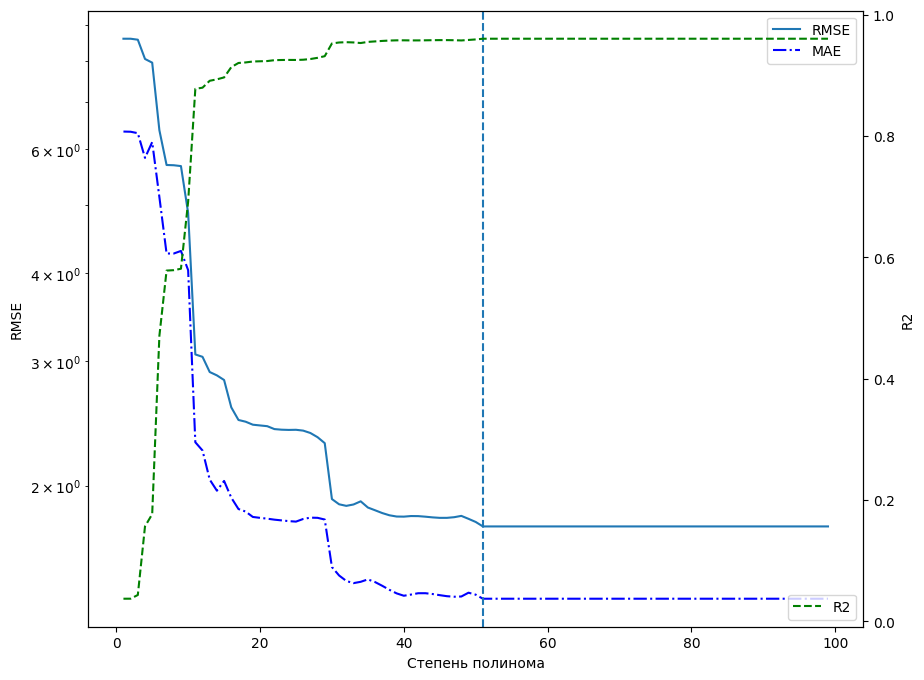

In [ ]:
x_train = np.arange(data_train.shape[0])

seed_everything()

rmses = []
maes = []
r2_scores = []
degrees = np.arange(1, 100)
min_rmse, min_mae, max_r2, min_deg, min_deg_mae, min_deg_r2 = 1e10, 1e10, 0.01, 0, 0, 0

for deg in degrees:

    model = np.polyfit(x = x_train, y = data_train, deg = deg)
    polynom = np.poly1d(model)

    df_polynom = pd.DataFrame(data=polynom(x_train))
    df_polynom = df_polynom.set_index(data_train.index)
    df_polynom.columns = ['Характерстика ДБ']
        
    # 1. RMSE:
    poly_mse = mean_squared_error(data_train, df_polynom) # Mean Square Error
    poly_rmse = np.sqrt(poly_mse) # Root Mean Square Root
    rmses.append(poly_rmse)
    
    # 2. MAE:
    poly_mae = mean_absolute_error(data_train, df_polynom)
    maes.append(poly_mae)
    
    # 3. R2 - score:
    poly_r2_score = r2_score(data_train, df_polynom)
    r2_scores.append(poly_r2_score)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg
    if min_mae > poly_mae:
        min_mae = poly_mae
        min_deg_mae = deg
    if max_r2 < poly_r2_score:
        max_r2 = poly_r2_score
        min_deg_r2 = deg

IPython.display.clear_output()
# Plot and present results
print('Лучшая степень {} для RMSE {},\n\t\t {} для MAE {},\n\t\t {} для R2 {}'.format(min_deg, min_rmse, min_deg_mae, min_mae, min_deg_r2, max_r2))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(degrees, rmses, label='RMSE')
ax2 = ax.twinx()
ax.plot(degrees, maes, 'b-.', label='MAE')
ax2.plot(degrees, r2_scores, 'g--', label='R2')
ax.set_yscale('log')
ax.set_xlabel('Степень полинома')
ax2.set_ylabel('R2')
ax.set_ylabel('MAE')
ax.set_ylabel('RMSE')
ax.axvline(51, linestyle='--')
ax.legend(loc='upper right')
ax2.legend(loc='lower right')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


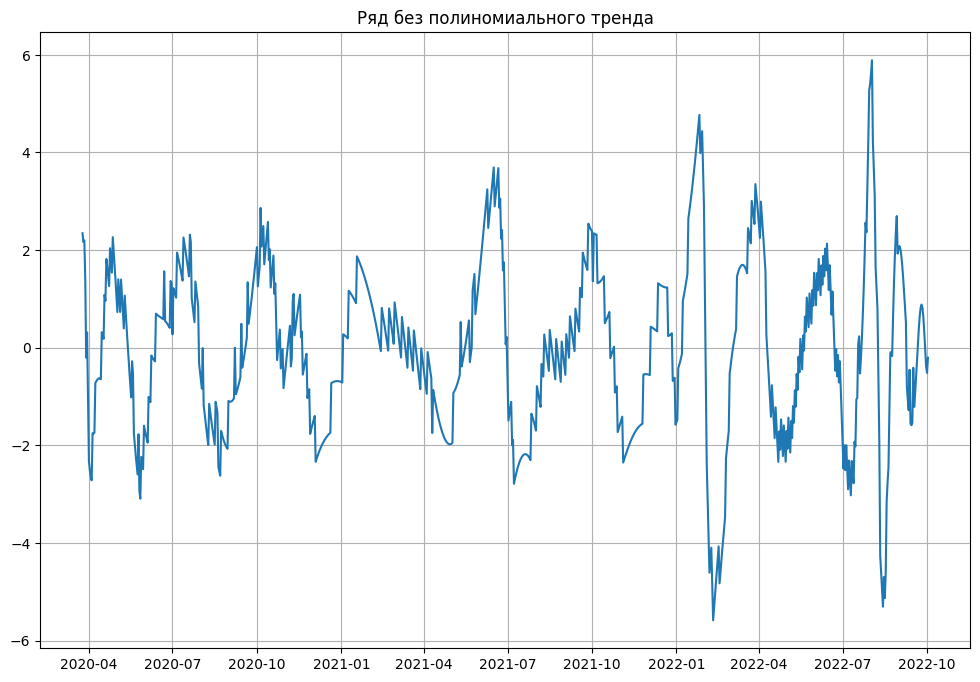

In [ ]:
model = np.polyfit(x = x_train, y = data_train, deg = 51)
polynom = np.poly1d(model)

df_polynom = pd.DataFrame(data=polynom(x_train))
df_polynom = df_polynom.set_index(data_train.index)
df_polynom.columns = ['Характерстика ДБ']
    
data_train_no_polinom = data_train - df_polynom['Характерстика ДБ']
plt.figure(figsize=(12,8))
plt.plot(data_train_no_polinom)
plt.grid()
plt.title('Ряд без полиномиального тренда')
# plt.xlim([410, 580])
plt.show()

In [ ]:
def check_stationarity(ts):
    dftest = sm.tsa.stattools.adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print(f'The series is stationary. p_value={pvalue}')
    else:
        print(f'The series is NOT stationary. p_value={pvalue}')

check_stationarity(data_train_no_polinom)

The series is stationary. p_value=3.3877446547094395e-09


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'Частичная автокорреляция')

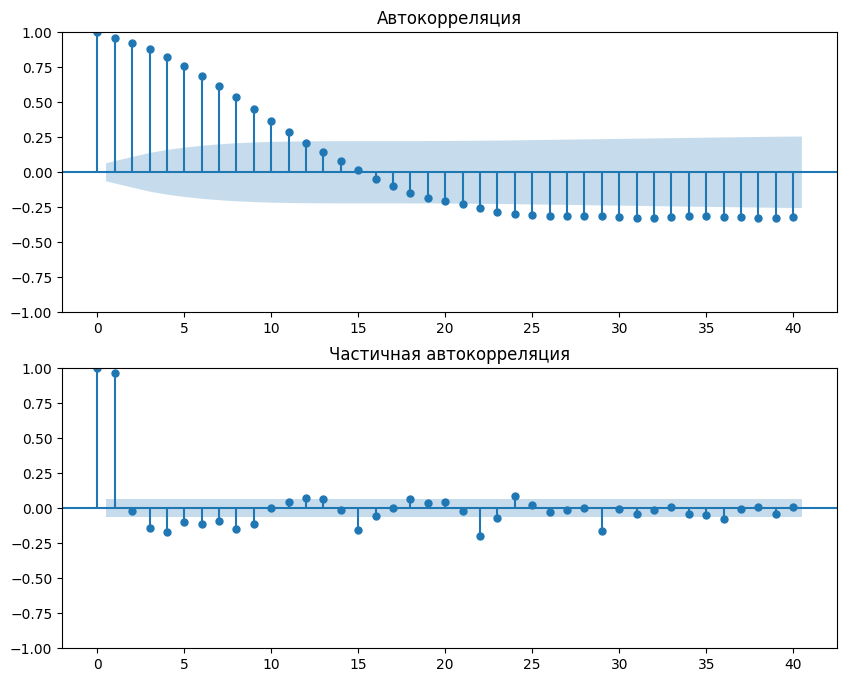

In [ ]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data_train_no_polinom, lags=40, ax=ax1)
ax1.set_title('Автокорреляция')
ax2 = fig.add_subplot(212)
fig = plot_pacf(data_train_no_polinom, lags=40, ax=ax2)
ax2.set_title('Частичная автокорреляция')

Text(0.5, 1.0, 'Частичная автокорреляция')

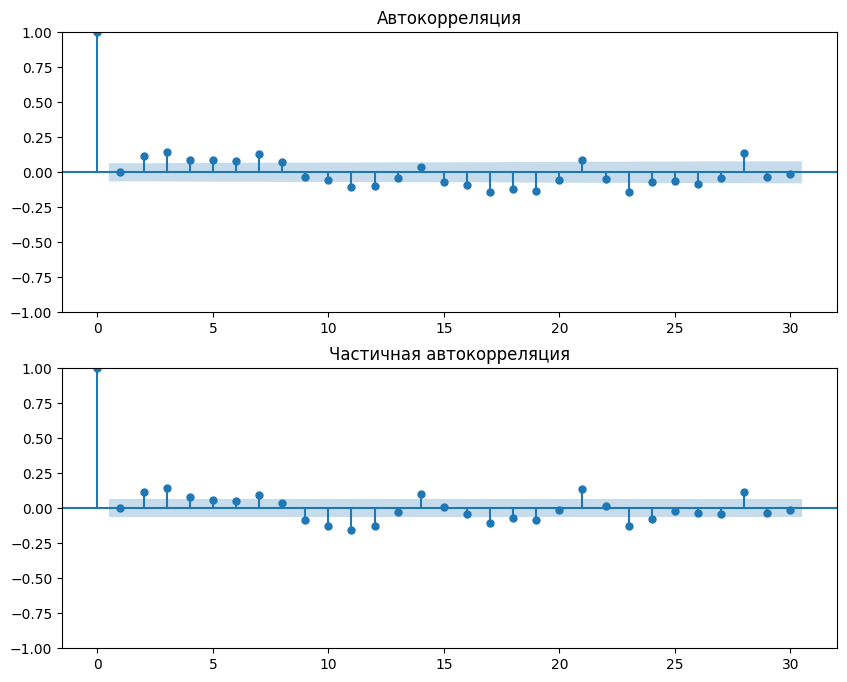

In [ ]:
diff1 = data_train_no_polinom.diff(1).dropna()

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(diff1, lags=30, ax=ax1)
ax1.set_title('Автокорреляция')
ax2 = fig.add_subplot(212)
fig = plot_pacf(diff1, lags=30, ax=ax2)
ax2.set_title('Частичная автокорреляция')

In [ ]:
#@title
conf = config(df_search)
seed_everything(conf.seed)

data_train = df_search.iloc[:conf.train_split, :]
data_test = df_search.iloc[conf.train_split:, :]

data_train = data_train['Характерстика ДБ']
data_test = data_test['Характерстика ДБ']


params_grid = {'p':np.arange(0,15), 
               'd':[1], 
               'q': np.arange(0, 15)}
grid = ParameterGrid(params_grid)
model_parameters = pd.DataFrame(columns = ['MAPE Test','R2','Parameters'])
for parameter in tqdm(grid):
    try:
        train_model = ARIMA(data_train, order=(parameter['p'], parameter['d'], parameter['q']))
        train_model = train_model.fit()
        pred_test = train_model.predict(start=data_test.index[0], end=data_test.index[-1])
        mape_test = mean_absolute_percentage_error(data_test, pred_test)
        r2_test = r2_score(data_test, pred_test)
        model_parameters = model_parameters.append({'MAPE Test': mape_test*100 ,'R2':r2_test , 'Parameters':parameter}, ignore_index=True)
    except:
        print('wrong parameters:', parameter)
        continue

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE Test'])
parameters = parameters.reset_index(drop=True)
parameters.head(10)

,MAPE Test,R2,Parameters
0,21.273118,0.100089,"{'d': 1, 'p': 13, 'q': 11}"
1,22.667469,0.011231,"{'d': 1, 'p': 13, 'q': 8}"
2,23.935775,-0.114147,"{'d': 1, 'p': 14, 'q': 8}"
3,25.789195,-0.263938,"{'d': 1, 'p': 13, 'q': 10}"
4,26.070224,-0.322942,"{'d': 1, 'p': 13, 'q': 13}"
5,29.045164,-0.583785,"{'d': 1, 'p': 13, 'q': 9}"
6,32.347331,-0.981411,"{'d': 1, 'p': 13, 'q': 12}"
7,35.693002,-1.454021,"{'d': 1, 'p': 12, 'q': 13}"
8,41.519291,-2.366231,"{'d': 1, 'p': 11, 'q': 13}"
9,44.135241,-2.754342,"{'d': 1, 'p': 11, 'q': 14}"


In [ ]:
conf = config(df_search)
seed_everything(conf.seed)

data_train = df_search.iloc[:conf.train_split, :]
data_val = df_search.iloc[conf.train_split:conf.val_split, :]
data_test = df_search.iloc[conf.train_split:, :]

data_train = data_train['Характерстика ДБ']
data_val = data_val['Характерстика ДБ']
data_test = data_test['Характерстика ДБ']

train_model = ARIMA(data_train, order=(13, 1, 11))
train_model = train_model.fit()
y_pred_arima = train_model.predict(start=data_test.index[0], end=data_test.index[-1])

## SARIMA

In [ ]:
#@title
conf = config(df_search)
seed_everything(conf.seed)

data_train = df_search.iloc[:conf.train_split, :]
data_test = df_search.iloc[conf.train_split:, :]

data_train = data_train['Характерстика ДБ']
data_test = data_test['Характерстика ДБ']


params_grid = {'ps':np.arange(0,5), 
               'd':[1], 
               'qs': np.arange(0, 7),
               'Ps': np.arange(0, 5),
               'D': [1],
               'Qs': np.arange(0, 7),
               }
grid = ParameterGrid(params_grid)
model_parameters_sarima = pd.DataFrame(columns = ['MAPE Test','R2','Parameters'])
for parameter in tqdm(grid):
    try:
        train_model = sm.tsa.statespace.SARIMAX(data_train, order=(parameter['ps'], parameter['d'], parameter['qs']), 
                                        seasonal_order=(parameter['Ps'], parameter['D'], parameter['Qs'], 90))
        train_model = train_model.fit()
        pred_test = train_model.predict(start=data_test.index[0], end=data_test.index[-1])
        mape_test = mean_absolute_percentage_error(data_test, pred_test)
        r2_test = r2_score(data_test, pred_test)
        model_parameters_sarima = model_parameters_sarima.append({'MAPE Test':mape_test*100 ,'R2': r2_test, 'Parameters':parameter}, ignore_index=True)
    except ValueError:
        print('wrong parameters:', parameter)
        continue

In [ ]:
parameters = model_parameters_sarima.sort_values(by=['MAPE Val'])
parameters = parameters.reset_index(drop=True)
parameters.head(10)

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE Val'])
parameters = parameters.reset_index(drop=True)
parameters.head(10)

,MAPE Val,MAPE Test,Parameters
0,19.023481,61.395145,"{'d': 1, 'p': 3, 'q': 0}"
1,20.008505,57.890414,"{'d': 1, 'p': 0, 'q': 13}"
2,26.971463,48.874354,"{'d': 1, 'p': 0, 'q': 10}"
3,27.012030,48.835544,"{'d': 1, 'p': 0, 'q': 11}"
4,27.448042,48.413653,"{'d': 1, 'p': 0, 'q': 12}"
5,29.130151,67.327247,"{'d': 1, 'p': 0, 'q': 14}"
6,29.166620,51.813270,"{'D': 1, 'Ps': 0, 'Qs': 1, 'd': 1, 'ps': 3, 'q..."
7,30.030057,46.270467,"{'d': 1, 'p': 0, 'q': 9}"
8,31.977219,44.661307,"{'d': 1, 'p': 0, 'q': 8}"
9,34.804705,42.359231,"{'d': 1, 'p': 0, 'q': 7}"


In [ ]:
parameters.iloc[6, -1]

{'D': 1, 'Ps': 0, 'Qs': 1, 'd': 1, 'ps': 3, 'qs': 0}

In [ ]:
conf = config(df_search)
seed_everything(conf.seed)

data_train = df_search.iloc[:conf.train_split, :]
data_val = df_search.iloc[conf.train_split:conf.val_split, :]
data_test = df_search.iloc[conf.train_split:, :]

data_train = data_train['Характерстика ДБ']
data_val = data_val['Характерстика ДБ']
data_test = data_test['Характерстика ДБ']

train_model = SARIMAX(data_train, order=(4, 1, 5), 
                            seasonal_order=(2, 1, 2, 90))
train_model = train_model.fit()
y_pred_sarima = train_model.predict(start=data_test.index[0], end=data_test.index[-1])

In [ ]:
data_train = df_search.iloc[:conf.train_split, :]
data_test = df_search.iloc[conf.train_split:, :]

X_train, y_train = data_train.iloc[:, :-1],  data_train.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1],  data_test.iloc[:, -1]

x_train = np.arange(X_train.shape[0])
x_test = np.arange(X_test.shape[0])

model = np.polyfit(x = x_train, y = y_train, deg = 50)
polynom = np.poly1d(model)

df_polynom = pd.DataFrame(data=polynom(np.arange(X_test.shape[0])))
df_polynom = df_polynom.set_index(X_test.index)
df_polynom.columns = ['Характерстика ДБ']

In [ ]:
conf = config(df_search)
seed_everything(conf.seed)

data_train = df_search.iloc[:conf.train_split, :]
data_test = df_search.iloc[conf.train_split:, :]

X_train, y_train = data_train.iloc[:, :-1],  data_train.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1],  data_test.iloc[:, -1]

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_linear = reg.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred_linear)*100
r2 = r2_score(y_test, y_pred_linear)
# plt.plot(X_test.index, y_pred_linear, label='Прогноз')
# plt.plot(X_test.index, y_test, label='Факт.')
# plt.title(f'Предсказание линейной модели. MAPE={round(mape, 2)} %. R2 = {round(r2, 2)}')
# plt.ylabel('Характеристика ДБ')
# plt.grid()
# plt.legend()

In [ ]:
x_train_2, y_train_2 = df_search.iloc[conf.train_split-120:conf.train_split, :-1], df_search.iloc[conf.train_split-120:conf.train_split, -1]
y_pred_linear_2 = reg.predict(x_train_2)

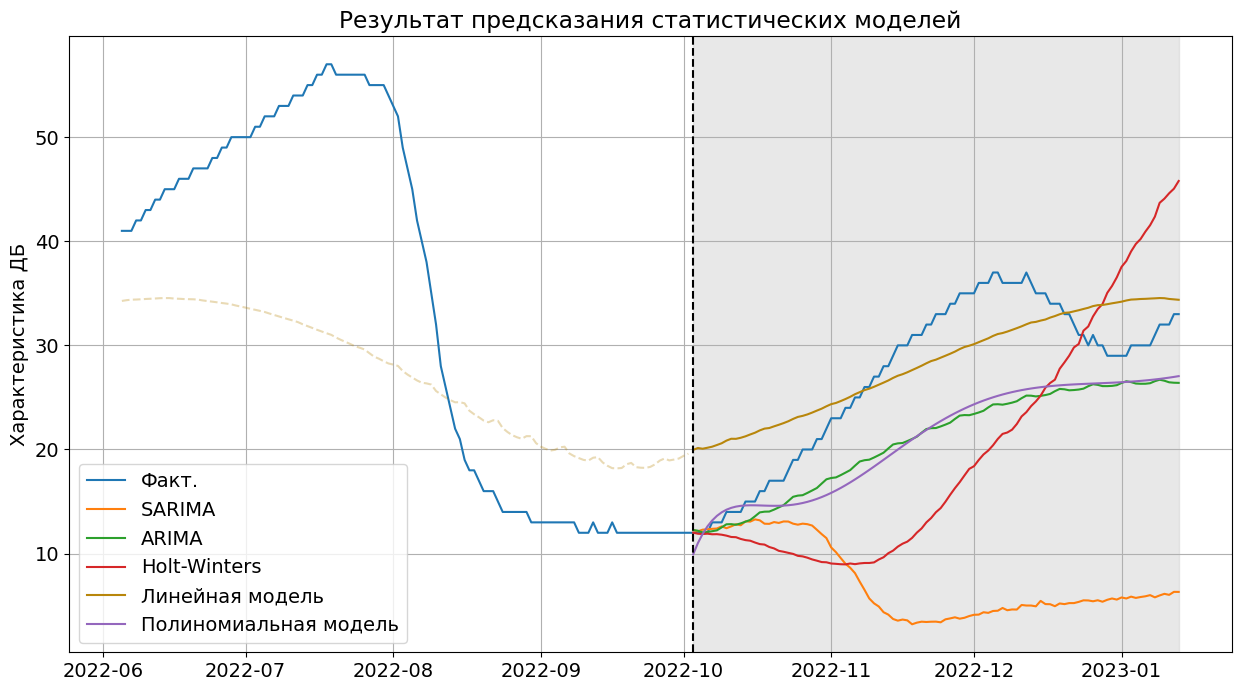

In [ ]:
mpl.rcParams['figure.figsize'] = (15, 8)
mpl.rcParams['axes.grid'] = False


plt.plot(df_search.index[conf.train_split-120:], df_search.iloc[conf.train_split-120:, -1], label='Факт.')
plt.plot(x_train_2.index, y_pred_linear_2, color='darkgoldenrod', alpha=0.3, linestyle='--')
plt.plot(data_test.index, y_pred_sarima, label='SARIMA')
plt.plot(data_test.index, y_pred_arima, label='ARIMA')
plt.plot(data_test.index, y_pred_holter_winters, label='Holt-Winters')
plt.plot(data_test.index, y_pred_linear, label='Линейная модель', color='darkgoldenrod')
plt.plot(data_test.index, df_polynom['Характерстика ДБ'], label='Полиномиальная модель')
plt.axvline(data_test.index[0], color='k', linestyle='--')
plt.axvspan(data_test.index[0], data_test.index[-1], alpha=0.5, color='lightgray')
plt.grid()
plt.legend()
plt.title('Результат предсказания статистических моделей')
plt.ylabel('Характеристика ДБ')
plt.show()

In [ ]:
pred_values = [y_pred_linear, y_pred_arima, y_pred_sarima, df_polynom['Характерстика ДБ'], y_pred_holter_winters]
mape_arr = []
r2_arr = []

i = 0
for pred in pred_values:
    mape = mean_absolute_percentage_error(data_test['Характерстика ДБ'], pred)*100
    r2 = r2_score(data_test['Характерстика ДБ'], pred)
    mape_arr.append(mape)
    r2_arr.append(r2)

index_data = ['Linear', 'ARIMA', 'SARIMA', 'Polynomial','Holter-Wintes']

dict_data = {'MAPE': mape_arr, 'R2': r2_arr}
df_metric = pd.DataFrame(dict_data, index=index_data)
df_metric = df_metric.sort_values(by=['MAPE'])
df_metric

,MAPE,R2
Linear,18.032016,0.673756
Polynomial,21.154289,0.132999
ARIMA,21.273118,0.100089
Holter-Wintes,38.354407,-1.557145
SARIMA,64.760084,-7.639091
